In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import modules.strings as strings
import sys
import os
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from modules.training import train_model, evaluate_metrics, train_regression_model
from torch.utils.data import DataLoader, TensorDataset

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
torch.manual_seed(42)

%matplotlib inline

In [2]:
data_path = strings.find(os.getcwd(), 'Cancer_patient_data_sets.csv')
data = pd.read_csv(data_path)

In [3]:
def text_to_num(text: str):
    levels = ["Low", "Medium", "High"]
    return levels.index(text) if text in levels else -1

In [4]:
# print(data.head())
print(data.isnull().sum()) # per vedere se ci sono valori mancanti (e stampa i nomi delle feature)

Age                         0
Gender                      0
Air Pollution               0
Alcohol use                 0
Dust Allergy                0
OccuPational Hazards        0
Genetic Risk                0
chronic Lung Disease        0
Balanced Diet               0
Obesity                     0
Smoking                     0
Passive Smoker              0
Chest Pain                  0
Coughing of Blood           0
Fatigue                     0
Weight Loss                 0
Shortness of Breath         0
Wheezing                    0
Swallowing Difficulty       0
Clubbing of Finger Nails    0
Frequent Cold               0
Dry Cough                   0
Snoring                     0
Level                       0
dtype: int64


In [5]:
x = torch.Tensor(data.drop("Level", axis=1).to_numpy())  # tutte le feature
y = torch.Tensor(np.apply_along_axis(text_to_num, 1, data["Level"].to_numpy().reshape(-1,1)))               # target: livello cancro
print(y.unique())  # stampa i livelli unici del target

assert -1 not in y, "There are invalid labels in the target variable."

print("x shape: ", x.shape)
print("y shape: ", y.shape)

print("x before scaling:\n ", x[:1])  # stampa le prime 5 righe delle feature
scaler = StandardScaler()
x = torch.Tensor(scaler.fit_transform(x))
print("x after scaling:\n ", x[:1])  # stampa le prime 5 righe delle feature dopo la normalizzazione

tensor([0., 1., 2.])
x shape:  torch.Size([1000, 23])
y shape:  torch.Size([1000])
x before scaling:
  tensor([[33.,  1.,  2.,  4.,  5.,  4.,  3.,  2.,  2.,  4.,  3.,  2.,  2.,  4.,
          3.,  4.,  2.,  2.,  3.,  1.,  2.,  3.,  4.]])
x after scaling:
  tensor([[-0.3478, -0.8199, -0.9067, -0.2150, -0.0833, -0.3987, -0.7432, -1.2882,
         -1.1670, -0.2189, -0.3800, -0.9500, -1.0697, -0.3540, -0.3815,  0.0657,
         -0.9808, -0.8707, -0.3287, -1.2246, -0.8386, -0.4186,  0.7287]])


In [6]:
# Divisione del dataset in training + test set, validation test
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.10, random_state=42)

# Divisione di training + test in due set separati
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
gamma = 0.95

middle_width = 2  # hidden layer width

# Define a simple NN
class SimpleClassifierNN(nn.Module):
    def __init__(self, X, Y):
        super().__init__()
        self.fc1 = nn.Linear(X_train.shape[1], middle_width)  # input layer to hidden layer
        self.fc2 = nn.Linear(middle_width, middle_width)
        self.fc3 = nn.Linear(middle_width, len(Y.unique()))  # hidden layer to output layer
        self.activation = nn.ReLU()
        print(self.fc1)

        # Loss and optimizer are defined here:
        self.criterion = nn.CrossEntropyLoss() # TODO: ADD L1 regularization
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=gamma)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x
    
class SimpleRegressorNN(nn.Module):
    def __init__(self, X, Y):
        super().__init__()
        self.fc1 = nn.Linear(X_train.shape[1], middle_width)  # input layer to hidden layer
        self.fc2 = nn.Linear(middle_width, middle_width)
        self.fc3 = nn.Linear(middle_width, 1)  # hidden layer to output layer
        self.activation = nn.ReLU()
        print(self.fc1)

        # Loss and optimizer are defined here:
        self.criterion = nn.MSELoss()  # Mean Squared Error for regression
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=gamma)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
# Create DataLoaders
batch_size = 32

train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

val_ds = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_ds, batch_size=len(y_val), shuffle=False)

test_ds = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=len(y_test), shuffle=False)

Linear(in_features=23, out_features=2, bias=True)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [32, 2]              48
              ReLU-2                    [32, 2]               0
            Linear-3                    [32, 2]               6
              ReLU-4                    [32, 2]               0
            Linear-5                    [32, 3]               9
Total params: 63
Trainable params: 63
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
Epoch 1/100 | Train Loss: 31.170 | Train Acc: 0.619 | Val Acc: 0.640
Epoch 2/100 | Train Loss: 30.098 | Train Acc: 0.651 | Val Acc: 0.640
Epoch 3/100 | Train Loss: 29.985 | Train Acc: 0.652 | Va

<Figure size 640x480 with 0 Axes>

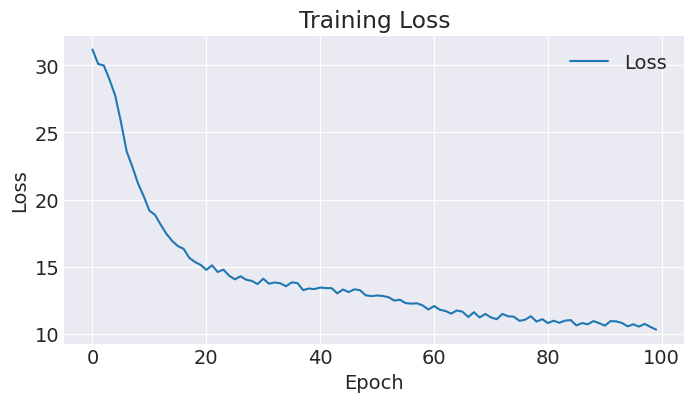

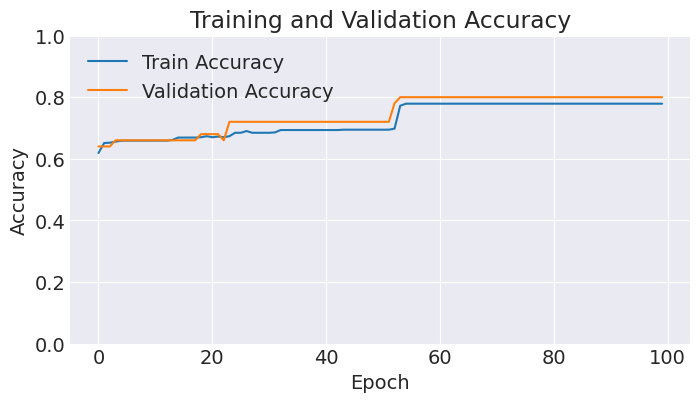

In [9]:
model = SimpleClassifierNN(X_train, y_train)
summary(model, input_size=X_train.shape[1:], batch_size=batch_size)
train_model(model, train_loader, val_loader, epochs=100)
evaluate_metrics(model, test_loader)

Linear(in_features=23, out_features=2, bias=True)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [32, 2]              48
              ReLU-2                    [32, 2]               0
            Linear-3                    [32, 2]               6
              ReLU-4                    [32, 2]               0
            Linear-5                    [32, 1]               3
Total params: 57
Trainable params: 57
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
Epoch 1/100 | Train Loss: 101.60 | Val Loss: 3.63 | Train Acc: 0.000 | Val Acc: 0.000
Epoch 2/100 | Train Loss: 95.69 | Val Loss: 3.37 | Train Acc: 0.000 | Val Acc: 0.000
Epoch 3/100 | Train Los

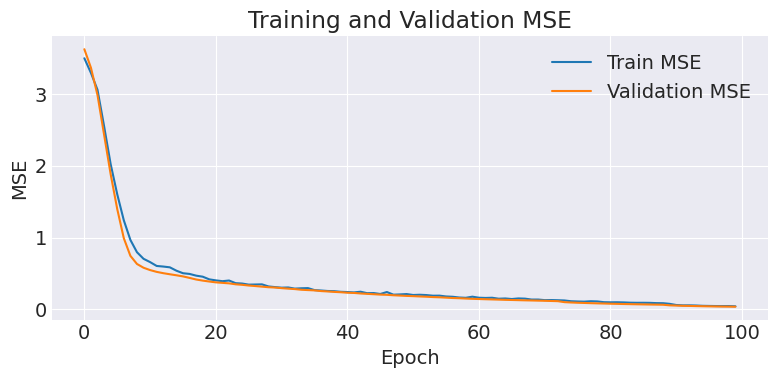

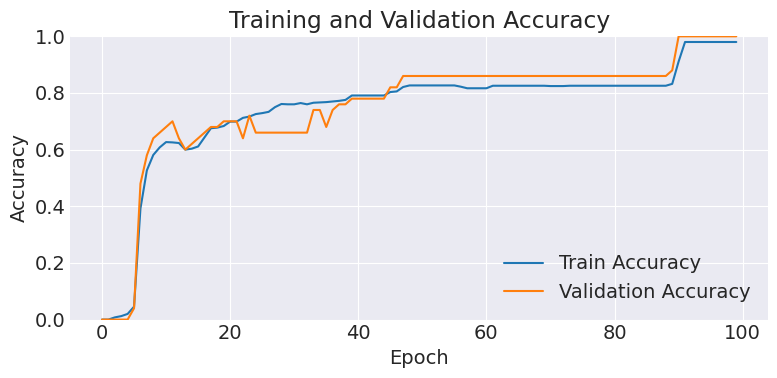

In [10]:
model = SimpleRegressorNN(X_train, y_train)
summary(model, input_size=X_train.shape[1:], batch_size=batch_size)
train_regression_model(model, train_loader, val_loader, epochs=100)
evaluate_metrics(model, test_loader, model_type='regression')

**Volendo potremmo provare ad utilizzare XGBoost, random forest e logistic regression e poi confrontare le performance tra i vari modelli (con cross validation/precision/recall/F1-score/confusion matrix).**

**FEATURE SELECTION** con random forrest gump

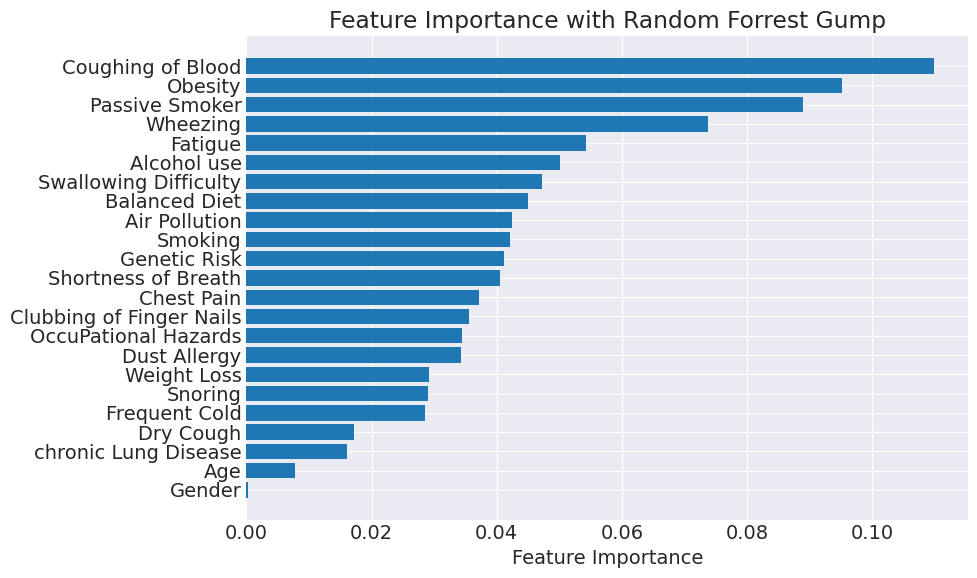

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Modello Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

X = data.drop("Level", axis=1)  # ⬅️ niente .values
y = (data["Level"] == "High").astype(int)  # esempio di target binario

# Identificazione features più importanti
importances = rf.feature_importances_
feature_names = X.columns  # se X è un DataFrame

# Crea un DataFrame
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Grafichino-ino-ino per capirci meglio
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.title("Feature Importance with Random Forrest Gump")
plt.grid(True)
plt.tight_layout()
plt.show()